In [2]:
import numpy as np
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
print("Tensorflow %s" %tf.__version__)

Tensorflow 2.3.1


In [29]:
import shutil
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
def dir_stats(path):
    print("stats on directory: " + path + ':\n')
    total = 0
    dirs = -1
    for s, d, files in os.walk(path):
        if len(d) > 0:
            print(s + ": " + str(len(d)) + " sub-directories")
        if len(files) > 0:
            print(s + ": " + str(len(files)) + " files")
        total += len(files)
        dirs += 1
    print('\n' + str(total) + " files in " + str(dirs) + " sub-directories")

# preprocessing

## preparing the dataset

In [6]:
db = './Dataset/socrates'

In [7]:
# dataset details
import pandas as pd
db_info = pd.read_excel('./Dataset/socrates_info.xlsx')
db_info = pd.DataFrame(db_info, columns=['ID', 'Model'])
print(db_info)

        ID                   Model
0    100.0         Motorola X Play
1    101.0       Samsung Galaxy S5
2    102.0                   LG G3
3    103.0          Apple iPhone 6
4    104.0       Samsung Galaxy S5
..     ...                     ...
98   219.0       Samsung Galaxy J7
99   220.0  Samsung Galaxy S4 Mini
100  224.0                   LG G3
101  225.0  Samsung Galaxy S7 Edge
102    NaN                     NaN

[103 rows x 2 columns]


## this code was used to organize the dataset in folders named after models' names

In [ ]:
# selected models from dataset
models = ['100', '101', '102', '103', '105', '110', '112', '113', '114', '115', '116', '117', '118', '119', '120', '123', '125', '127']
for m in models:
    os.makedirs(os.path.join(db, db_info[db_info['ID']==int(m)]['Model'].to_list()[0].strip().replace(" ", "_")), exist_ok=True)

In [ ]:
for _, _, files in os.walk(os.path.join(db, 'dataset')):
    for f in files:
        if any(m in f for m in models):
            if '.jpg' in f or '.JPG' in f:
                index = f[8:11]
                dst = db_info[db_info['ID']==int(index)]['Model'].to_list()[0].strip().replace(" ", "_")
                print(dst)
                print(f)
                shutil.move(os.path.join(db, f), os.path.join(db, dst, f))
            

In [ ]:
dir_stats(db)

stats on directory: Dataset/socrates:

Dataset/socrates: 18 sub-directories
Dataset/socrates/Samsung_Galaxy_S6_Edge: 96 files
Dataset/socrates/Samsung_Galaxy_S5: 90 files
Dataset/socrates/Huawei_P8_Lite: 90 files
Dataset/socrates/Wiko_Birdy_4G: 90 files
Dataset/socrates/Acer_Liquid_E700: 90 files
Dataset/socrates/Huawei_P7: 90 files
Dataset/socrates/Apple_iPhone_5c: 90 files
Dataset/socrates/Sony_Xperia_Z5: 90 files
Dataset/socrates/Apple_iPhone_6: 90 files
Dataset/socrates/Motorola_X_Play: 90 files
Dataset/socrates/Wiko_Rainbow_4G: 90 files
Dataset/socrates/LG_G3: 90 files
Dataset/socrates/Samsung_Galaxy_Core_Prime: 90 files
Dataset/socrates/Nokia_Lumia_635: 90 files
Dataset/socrates/LG_G4: 90 files
Dataset/socrates/Apple_iPhone_6s: 90 files
Dataset/socrates/Sony_Xperia_Z1_Compact: 90 files
Dataset/socrates/Motorola_Moto_G: 100 files

1636 files in 18 sub-directories


## splitfolders

In [1]:
# divide dataset in train and val
import splitfolders
try:
    os.makedirs("./data")
except OSError:
    print('dataset already subdivided')
else:
    splitfolders.ratio(db, output="data", seed=1998, ratio=(.7,.3))

dataset already subdivided


## divide in patches

In [8]:
# takes the first "k" 64x64 non-overlapping patches in the image
def get_patches(img, k):
    patches = []
    img = np.array(img)
    counter = k
    for i in range(img.shape[0]//64):
        for j in range(img.shape[1]//64):
            if counter == 0:
                break
            patch = img[64*i:64*(i+1), 64*j:64*(j+1)]
            patches.append(patch)
            counter -= 1
    return patches

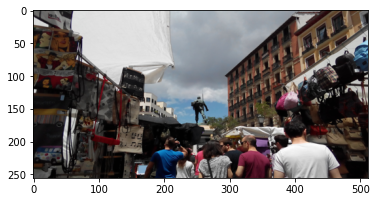

In [10]:
# sample image and resize
for _,_,files in os.walk(db + '/Acer_Liquid_E700'):
    img = Image.open(db + '/Acer_Liquid_E700/' + files[59])
    img = img.resize((512,256))
    plt.imshow(img)
    plt.show

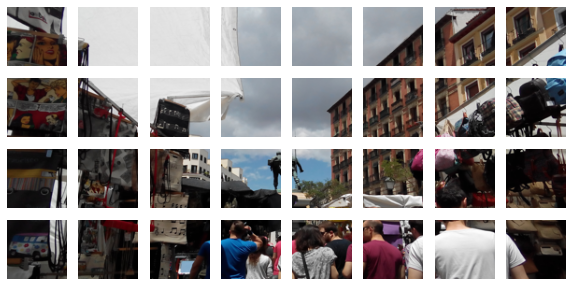

In [11]:
# get_patches in action on sample image
ps = get_patches(img,32)
counter = 0
f, a = plt.subplots(4,8, figsize=(10,5))
for i in range(len(a)):
    for j in range(len(a[i])):
        a[i, j].imshow(ps[counter])
        a[i, j].axis('off')
        counter +=1

In [32]:
# apply get_patches to dataset, select only midrange ones and calculate average color from all images
def patchify(src, dst):
    n_original_patches = 0
    n_patches = 0
    avgs = []
    for d in os.listdir(src):
        os.makedirs(os.path.join(dst, d), exist_ok=True)
        for _, _, files in os.walk(os.path.join(src, d)):
            for f in tqdm(files, desc=f"model: {d}", position=0):
                img = Image.open(os.path.join(src, d, f))
                img = img.resize((512,256))
                avgs.append(np.average(img, (0,1)))
                patches = get_patches(img, 32)
                for i in range(len(patches)):
                    n_original_patches += 1
                    if np.sum(np.average(patches[i], (0,1)))>57 and np.sum(np.average(patches[i], (0,1)))<708:
                        n_patches+=1
                        Image.fromarray(patches[i]).save(os.path.join(dst, d, f.replace(".JPG", ".jpg").replace(".jpg","_p_"+str(i)+".jpg")))
    avg = np.average(np.array(avgs),axis=0)
    tqdm.write("\nonly " + str(n_patches) + " selected out of " + str(n_original_patches)+"\n")
    return avg

In [33]:
os.makedirs('patches', exist_ok=True)
os.makedirs('patches/train', exist_ok=True)
os.makedirs('patches/val', exist_ok=True)
train_avg = patchify('data/train', 'patches/train')
val_avg = patchify('data/val', 'patches/val')

model: Acer_Liquid_E700:   4%|▎         | 1/28 [00:00<00:04,  6.29it/s]
only 35845 selected out of 36128

model: Wiko_Rainbow_4G: 100%|██████████| 62/62 [06:24<00:00,  6.04it/s]
only 16119 selected out of 16224



In [34]:
dir_stats('patches')

stats on directory: patches:

patches: 2 sub-directories
patches\train: 18 sub-directories
patches\train\Acer_Liquid_E700: 1941 files
patches\train\Apple_iPhone_5c: 1954 files
patches\train\Apple_iPhone_6: 1984 files
patches\train\Apple_iPhone_6s: 1983 files
patches\train\Huawei_P7: 1984 files
patches\train\Huawei_P8_Lite: 1969 files
patches\train\LG_G3: 1979 files
patches\train\LG_G4: 1977 files
patches\train\Motorola_Moto_G: 2197 files
patches\train\Motorola_X_Play: 1984 files
patches\train\Nokia_Lumia_635: 1951 files
patches\train\Samsung_Galaxy_Core_Prime: 1963 files
patches\train\Samsung_Galaxy_S5: 1968 files
patches\train\Samsung_Galaxy_S6_Edge: 2120 files
patches\train\Sony_Xperia_Z1_Compact: 1962 files
patches\train\Sony_Xperia_Z5: 1977 files
patches\train\Wiko_Birdy_4G: 1980 files
patches\train\Wiko_Rainbow_4G: 1972 files
patches\val: 18 sub-directories
patches\val\Acer_Liquid_E700: 892 files
patches\val\Apple_iPhone_5c: 874 files
patches\val\Apple_iPhone_6: 896 files
patches\

## get averages (if not saved earlier)


In [ ]:
def get_avg(dir):
    avgs = []
    for d in os.listdir(dir):
        for _, _, files in os.walk(os.path.join(dir, d)):
            for f in files:
                img = Image.open(os.path.join(dir, d, f))
                img = img.resize((512,512))
                avgs.append(np.average(img, (0,1)))
    avg = np.average(np.array(avgs), axis=0)
    return avg

In [ ]:
try:
    train_avg
except NameError:
    train_avg = get_avg('data/train')
else:
    print('train average already defined')
try:
    val_avg
except NameError:
    val_avg = get_avg('data/val')
else:
    print('val average already defined')

train average already defined
val average already defined


In [37]:
print(train_avg)
print(val_avg)

[120.56748315 140.25956522 158.70004408]
[122.79595368 143.16819149 163.37074202]


In [36]:
# hard coded averages for simplicity
train_avg = np.array([120.56748315, 140.25956522, 158.70004408])
val_avg = np.array([122.79595368, 143.16819149, 163.37074202])


# Preparing data generators

In [38]:
train_dir = 'patches/train'
val_dir = 'patches/val'
batch_size = 128

def train_preproc(img):
    return (img-train_avg)*0.0125

train_datagen = ImageDataGenerator(
    preprocessing_function=train_preproc
)

def val_preproc(img):
    return (img-val_avg)*0.0125

val_datagen = ImageDataGenerator(
    preprocessing_function=val_preproc
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True # shuffling for training
)

val_generator = train_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
)
n_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(n_samples,num_classes))
print('Loaded %d validation samples from %d classes.' %(val_generator.n,val_generator.num_classes))


Found 35845 images belonging to 18 classes.
Found 16119 images belonging to 18 classes.
Image input (64, 64, 3)
Classes: ['Acer_Liquid_E700', 'Apple_iPhone_5c', 'Apple_iPhone_6', 'Apple_iPhone_6s', 'Huawei_P7', 'Huawei_P8_Lite', 'LG_G3', 'LG_G4', 'Motorola_Moto_G', 'Motorola_X_Play', 'Nokia_Lumia_635', 'Samsung_Galaxy_Core_Prime', 'Samsung_Galaxy_S5', 'Samsung_Galaxy_S6_Edge', 'Sony_Xperia_Z1_Compact', 'Sony_Xperia_Z5', 'Wiko_Birdy_4G', 'Wiko_Rainbow_4G']
Loaded 35845 training samples from 18 classes.
Loaded 16119 validation samples from 18 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0:00:00.046404


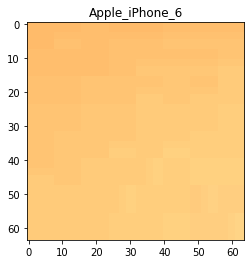

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


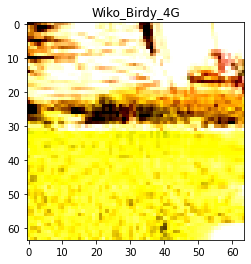

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


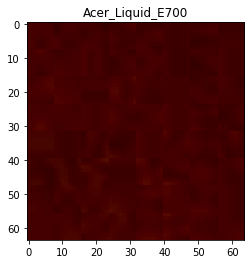

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


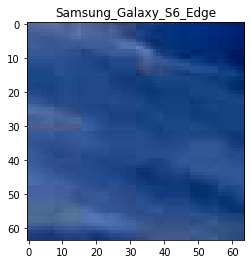

In [ ]:
%matplotlib inline
import random
from datetime import datetime
old = datetime.now()
x, y = train_generator.next()
elapsed = datetime.now() - old
print(elapsed)

for i in range(0,4):
    j = random.randint(0,127)
    image = x[j]
    plt.imshow(image)
    plt.title(classnames[y[j].argmax()])
    plt.show()

# CNN

In [39]:
def CNNModel(input_shape, num_classes):
    model = Sequential(name="sequential")

    model.add(Conv2D(filters = 32, kernel_size = 4, strides=1, padding='same', input_shape=input_shape, name="conv1"))
    model.add(MaxPooling2D(pool_size = 2, strides=2, name="pool1"))
    model.add(Conv2D(filters = 48, kernel_size = 5, strides=1, name="conv2"))
    model.add(MaxPooling2D(pool_size = 2, strides=2, name="pool2"))
    model.add(Conv2D(filters = 64, kernel_size = 5, strides=1, name="conv3"))
    model.add(MaxPooling2D(pool_size = 2, strides=2, name="pool3"))
    model.add(Conv2D(filters = 128, kernel_size = 5, strides=1, name="conv4"))
    
    model.add(Flatten(name="flatten"))
    
    model.add(Dense(128, name="ip1"))
    model.add(Activation('relu', name="relu1"))
    model.add(Dense(num_classes, name="ip2"))
    model.add(Activation('softmax', name="softmax"))

    sgd = tf.keras.optimizers.SGD(learning_rate=0.015, momentum=0.9, decay = 7.5e-3)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model = CNNModel(input_shape, num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        1568      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 48)        38448     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 48)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 10, 10, 64)        76864     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv4 (Conv2D)               (None, 1, 1, 128)         2

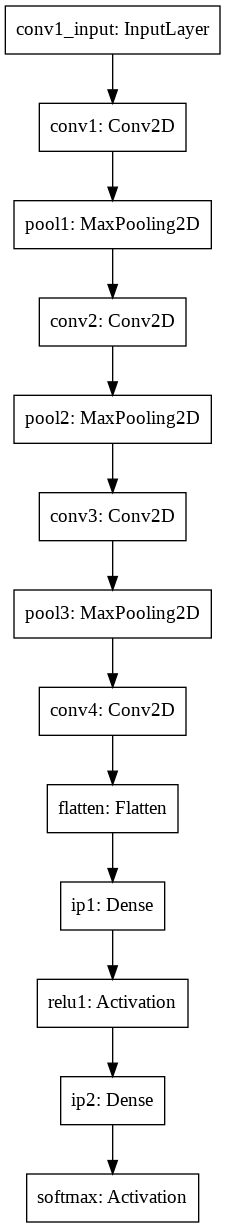

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
train_steps=train_generator.n//train_generator.batch_size
val_steps=val_generator.n//val_generator.batch_size+1
print("Steps per training epoch: " + str(train_steps))
print("Steps per evaluation epoch: " + str(val_steps))
epochs = 50
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        print("Learning rate halved to ", lr*0.5)
        return lr * 0.5
    return lr
lr_sched = tf.keras.callbacks.LearningRateScheduler(scheduler)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoints/best_val_loss.hdf5', save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')

os.makedirs('checkpoints', exist_ok=True)
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[lr_sched, earlyStopping, checkpoint])

Steps per training epoch: 280
Steps per evaluation epoch: 126
Epoch 1/50
281/281 [==============================] - 54s 81ms/step - loss: 2.1388 - accuracy: 0.3327 - val_loss: 1.8352 - val_accuracy: 0.4204
Epoch 2/50
281/281 [==============================] - 21s 75ms/step - loss: 1.7145 - accuracy: 0.4724 - val_loss: 1.6044 - val_accuracy: 0.4926
Epoch 3/50
281/281 [==============================] - 21s 76ms/step - loss: 1.5219 - accuracy: 0.5344 - val_loss: 1.5369 - val_accuracy: 0.5548
Epoch 4/50
281/281 [==============================] - 21s 75ms/step - loss: 1.4165 - accuracy: 0.5717 - val_loss: 1.4562 - val_accuracy: 0.5830
Epoch 5/50
281/281 [==============================] - 21s 75ms/step - loss: 1.3479 - accuracy: 0.5914 - val_loss: 1.4062 - val_accuracy: 0.5856
Epoch 6/50
281/281 [==============================] - 21s 75ms/step - loss: 1.2708 - accuracy: 0.6135 - val_loss: 1.3394 - val_accuracy: 0.6173
Epoch 7/50
281/281 [==============================] - 21s 75ms/step - loss

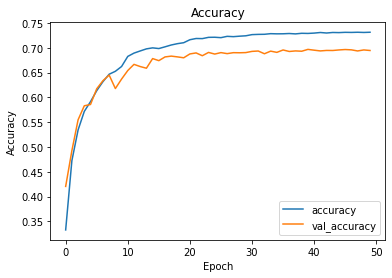

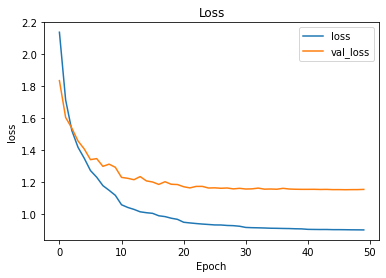

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.load_weights('./checkpoints/best_val_loss.hdf5')
loss, acc = model.evaluate(val_generator)

126/126 [==============================] - 6s 48ms/step - loss: 1.1507 - accuracy: 0.6958


# get model ready for SVM training

In [ ]:
svm_ready = Sequential(model.layers[:-2], name="sequential")

for i in range(len(svm_ready.layers)):
    svm_ready.layers[i].trainable = False
    
svm_ready.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        1568      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 48)        38448     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 48)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 10, 10, 64)        76864     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv4 (Conv2D)               (None, 1, 1, 128)         2

# SVM classifier training

## load train dataset for SVM

In [ ]:
x_train , y_train = [] , []
train_generator.reset()

for i in tqdm(range(train_generator.n//batch_size + 1)):
    a , b = train_generator.next()
    x_train.extend(a) 
    y_train.extend(b)
y_train = np.argmax(y_train, axis=1)

100%|██████████| 281/281 [00:11<00:00, 23.73it/s]


## predict with CNN

In [ ]:
X_train = svm_ready.predict(np.array(x_train))

## scale result

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)

In [ ]:
print(scaled_X_train.shape)

(35845, 128)


## prepare and train linear SVM OneVsOne

In [ ]:
from sklearn import svm
clf = svm.LinearSVC(random_state=0, verbose=True, fit_intercept=False, dual=False, C=5.0)

In [ ]:
from sklearn import multiclass

In [ ]:
clf = multiclass.OneVsOneClassifier(clf, n_jobs=-1).fit(scaled_X_train, y_train)

# testing

## load test dataset and average

In [ ]:
x_val, y_val, val_avgs = [], [], []
for d in os.listdir('data/val'):  
    for _, _, files in os.walk('data/val/'+d):
        for f in files:
            img = Image.open('data/val/'+d+"/"+f)
            img = img.resize((512,256))
            x_val.append(img)
            y_val.append(classnames.index(d))
            val_avgs.append(np.average(img, axis=(0,1)))

In [ ]:
val_avg = np.average(np.array(val_avgs), axis=0)

In [ ]:
results = []
for j in tqdm(range(len(x_val))):
    patches = get_patches(x_val[j], 32)
    best_patches = []
    for patch in patches:
        if np.sum(np.average(patch, (0,1)))>57 and np.sum(np.average(patch, (0,1)))<708:
            best_patches.append((patch-val_avg)*0.0125)
    best_patches = np.array(best_patches)
    # CNN prediction
    cnn_pred = model_2.predict(best_patches)
    # scaling
    scaled_cnn_pred = scaler.transform(cnn_pred)
    # svm prediction
    svm_pred = clf.predict(scaled_cnn_pred)
    # majority voting
    elected_class = np.argmax(np.bincount(np.array(svm_pred)))
    results.append(elected_class)

100%|██████████| 507/507 [00:33<00:00, 14.95it/s]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

In [ ]:
print(classification_report(y_val, results, labels=None, target_names=classnames, digits=3))

                           precision    recall  f1-score   support

         Acer_Liquid_E700      0.676     0.821     0.742        28
          Apple_iPhone_5c      0.667     0.857     0.750        28
           Apple_iPhone_6      1.000     1.000     1.000        28
          Apple_iPhone_6s      0.793     0.821     0.807        28
                Huawei_P7      0.810     0.607     0.694        28
           Huawei_P8_Lite      0.700     0.750     0.724        28
                    LG_G3      0.727     0.857     0.787        28
                    LG_G4      0.643     0.643     0.643        28
          Motorola_Moto_G      1.000     0.433     0.605        30
          Motorola_X_Play      1.000     1.000     1.000        28
          Nokia_Lumia_635      0.800     0.714     0.755        28
Samsung_Galaxy_Core_Prime      0.870     0.714     0.784        28
        Samsung_Galaxy_S5      0.405     0.536     0.462        28
   Samsung_Galaxy_S6_Edge      0.771     0.931     0.844     

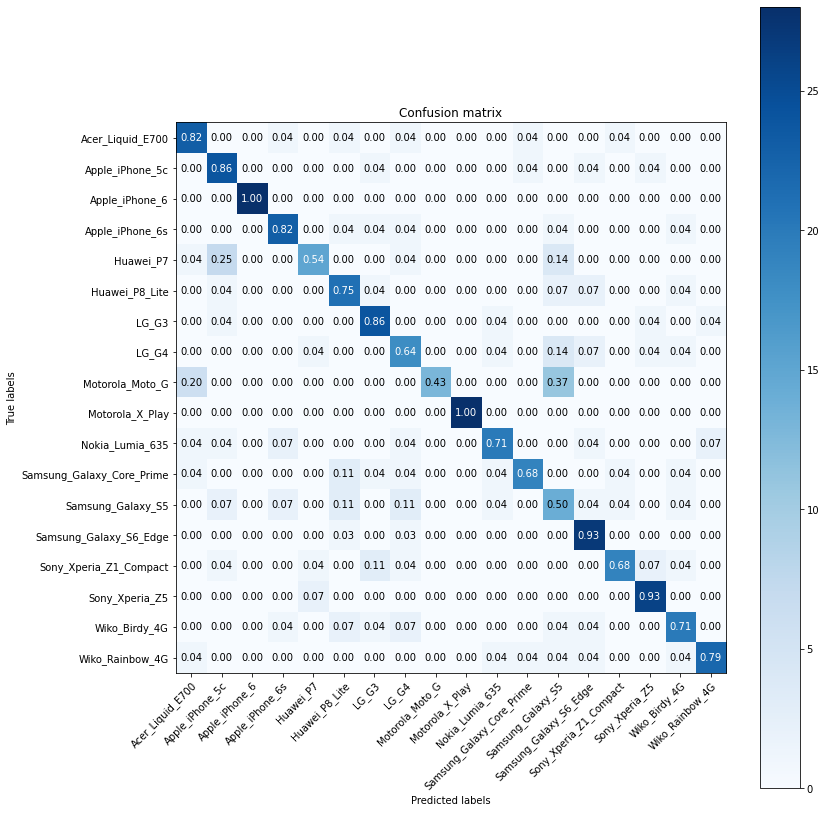

In [ ]:
cm = confusion_matrix(y_val, results)


plt.figure(figsize=(12,12))

plt.imshow(cm, cmap=plt.cm.Blues)

plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=45,rotation_mode="anchor", ha='right')
plt.yticks(tick_marks, classnames)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
              ha="center", va="center",
              color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")

plt.show()